# 스타벅스 재방문 동기 분석

- 분석일: 2023.08.31 ~ 2023.09.01

## 목차

1. [개요](#1.-개요)


2. [데이터 셋 로딩](#2.-데이터-셋-로딩)


3. [EDA 및 데이터 전처리](#3.-EDA-및-데이터-전처리)

    3-1. [불필요한 데이터 제거](#3-1.-불필요한-데이터-제거)
    
    3-2. [데이터 살펴보기](#3-2.-데이터-살펴보기)
    
    3-3. [빈 값 처리](#3-3.-빈-값-처리)
    
    3-4. [범주형 데이터 처리](#3-4.-범주형-데이터-처리)
    
    3-5. [데이터 분리](#3-5.-데이터-분리)
    
    
4. [Logistic Regression 모델 생성](#4.-Logistic-Regression-모델-생성)

    4-1. [train-test-split](#4-1.-train-test-split)

    4-2. [모델 생성 및 튜닝](#4-2.-모델-생성-및-튜닝)
    
    4-3. [모델 성능 평가](#4-3.-모델-성능-평가)


5. [요인 별 중요도](#5.-요인-별-중요도)


6. [후기](#6.-후기)

## 1. 개요

- 분석 목적: 스타벅스 **재방문 의사**에 영향을 미치는 요인 알아보기
- 분석 대상: Starbucks Customer Survey (말레이시아 스타벅스 소비자 설문 결과 데이터)
    - https://www.kaggle.com/datasets/mahirahmzh/starbucks-customer-retention-malaysia-survey?datasetId=636300
- 분석 모델: Logistic Regression (성능: F1-score 0.86)

## 2. 데이터 셋 로딩

In [1]:
import pandas as pd
import numpy as np

starbucks_df = pd.read_csv('Starbucks satisfactory survey.csv')

In [2]:
starbucks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 21 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Timestamp                                                                                                               122 non-null    object
 1   1. Your Gender                                                                                                          122 non-null    object
 2   2. Your Age                                                                                                             122 non-null    object
 3   3. Are you currently....?                                                                                               122 non-null    object
 4   4.

In [3]:
starbucks_df.head()

,Timestamp,1. Your Gender,2. Your Age,3. Are you currently....?,4. What is your annual income?,5. How often do you visit Starbucks?,6. How do you usually enjoy Starbucks?,7. How much time do you normally spend during your visit?,8. The nearest Starbucks's outlet to you is...?,9. Do you have Starbucks membership card?,...,"11. On average, how much would you spend at Starbucks per visit?","12. How would you rate the quality of Starbucks compared to other brands (Coffee Bean, Old Town White Coffee..) to be:",13. How would you rate the price range at Starbucks?,14. How important are sales and promotions in your purchase decision?,"15. How would you rate the ambiance at Starbucks? (lighting, music, etc...)",16. You rate the WiFi quality at Starbucks as..,"17. How would you rate the service at Starbucks? (Promptness, friendliness, etc..)",18. How likely you will choose Starbucks for doing business meetings or hangout with friends?,19. How do you come to hear of promotions at Starbucks? Check all that apply.,20. Will you continue buying at Starbucks?
0,2019/10/01 12:38:43 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,within 1km,Yes,...,Less than RM20,4,3,5,5,4,4,3,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
1,2019/10/01 12:38:54 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,1km - 3km,Yes,...,Less than RM20,4,3,4,4,4,5,2,Social Media;In Store displays,Yes
2,2019/10/01 12:38:56 PM GMT+8,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 30 minutes to 1 hour,more than 3km,Yes,...,Less than RM20,4,3,4,4,4,4,3,In Store displays;Billboards,Yes
3,2019/10/01 12:39:08 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,more than 3km,No,...,Less than RM20,2,1,4,3,3,3,3,Through friends and word of mouth,No
4,2019/10/01 12:39:20 PM GMT+8,Male,From 20 to 29,Student,"Less than RM25,000",Monthly,Take away,Between 30 minutes to 1 hour,1km - 3km,No,...,Around RM20 - RM40,3,3,4,2,2,3,3,Starbucks Website/Apps;Social Media,Yes


In [4]:
# 헤더 명칭 한글화
headers = [
    '타임스탬프', '성별', '나이대', '고용 상태', '수입', '방문 빈도', '구매 유형', '체류 시간', '매장과의 거리', '멤버십 가입 여부',
    '가장 선호하는 메뉴', '방문 당 지출 비용', '타사 대비 퀄리티 평가', '가격대 평가', '프로모션의 중요도', '매장 분위기 평가',
    'Wi-Fi 퀄리티 평가', '서비스 평가', '비즈니스/친목 목적 방문 가능성', '프로모션을 접한 경로', '재방문 의사'
]

starbucks_df.columns = headers
starbucks_df

,타임스탬프,성별,나이대,고용 상태,수입,방문 빈도,구매 유형,체류 시간,매장과의 거리,멤버십 가입 여부,...,방문 당 지출 비용,타사 대비 퀄리티 평가,가격대 평가,프로모션의 중요도,매장 분위기 평가,Wi-Fi 퀄리티 평가,서비스 평가,비즈니스/친목 목적 방문 가능성,프로모션을 접한 경로,재방문 의사
0,2019/10/01 12:38:43 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,within 1km,Yes,...,Less than RM20,4,3,5,5,4,4,3,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
1,2019/10/01 12:38:54 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,1km - 3km,Yes,...,Less than RM20,4,3,4,4,4,5,2,Social Media;In Store displays,Yes
2,2019/10/01 12:38:56 PM GMT+8,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 30 minutes to 1 hour,more than 3km,Yes,...,Less than RM20,4,3,4,4,4,4,3,In Store displays;Billboards,Yes
3,2019/10/01 12:39:08 PM GMT+8,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,more than 3km,No,...,Less than RM20,2,1,4,3,3,3,3,Through friends and word of mouth,No
4,2019/10/01 12:39:20 PM GMT+8,Male,From 20 to 29,Student,"Less than RM25,000",Monthly,Take away,Between 30 minutes to 1 hour,1km - 3km,No,...,Around RM20 - RM40,3,3,4,2,2,3,3,Starbucks Website/Apps;Social Media,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2019/10/04 12:24:26 AM GMT+8,Male,40 and above,Self-employed,"RM25,000 - RM50,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,...,Around RM20 - RM40,3,3,5,3,2,4,4,Starbucks Website/Apps;Social Media,Yes
118,2019/10/04 9:30:09 AM GMT+8,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,...,More than RM40,5,5,5,5,5,5,5,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
119,2019/10/04 1:46:07 PM GMT+8,Male,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,1km - 3km,No,...,Less than RM20,3,2,4,3,3,3,4,Social Media;Through friends and word of mouth...,No
120,2019/10/05 11:01:14 AM GMT+8,Female,From 20 to 29,Employed,"Less than RM25,000",Rarely,Take away,Below 30 minutes,within 1km,No,...,Less than RM20,4,4,4,4,4,4,4,Social Media;Through friends and word of mouth...,Yes


## 3. EDA 및 데이터 전처리

### 3-1. 불필요한 데이터 제거

In [5]:
# 타임스탬프 제거
starbucks_df = starbucks_df.drop('타임스탬프', axis=1)
starbucks_df

,성별,나이대,고용 상태,수입,방문 빈도,구매 유형,체류 시간,매장과의 거리,멤버십 가입 여부,가장 선호하는 메뉴,방문 당 지출 비용,타사 대비 퀄리티 평가,가격대 평가,프로모션의 중요도,매장 분위기 평가,Wi-Fi 퀄리티 평가,서비스 평가,비즈니스/친목 목적 방문 가능성,프로모션을 접한 경로,재방문 의사
0,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,within 1km,Yes,Coffee,Less than RM20,4,3,5,5,4,4,3,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
1,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,1km - 3km,Yes,Cold drinks;Pastries,Less than RM20,4,3,4,4,4,5,2,Social Media;In Store displays,Yes
2,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 30 minutes to 1 hour,more than 3km,Yes,Coffee,Less than RM20,4,3,4,4,4,4,3,In Store displays;Billboards,Yes
3,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,more than 3km,No,Coffee,Less than RM20,2,1,4,3,3,3,3,Through friends and word of mouth,No
4,Male,From 20 to 29,Student,"Less than RM25,000",Monthly,Take away,Between 30 minutes to 1 hour,1km - 3km,No,Coffee;Sandwiches,Around RM20 - RM40,3,3,4,2,2,3,3,Starbucks Website/Apps;Social Media,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Male,40 and above,Self-employed,"RM25,000 - RM50,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,Coffee,Around RM20 - RM40,3,3,5,3,2,4,4,Starbucks Website/Apps;Social Media,Yes
118,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,Coffee;Cold drinks;Juices;Pastries;Sandwiches,More than RM40,5,5,5,5,5,5,5,Starbucks Website/Apps;Social Media;Emails;Dea...,Yes
119,Male,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,1km - 3km,No,Coffee;Cold drinks,Less than RM20,3,2,4,3,3,3,4,Social Media;Through friends and word of mouth...,No
120,Female,From 20 to 29,Employed,"Less than RM25,000",Rarely,Take away,Below 30 minutes,within 1km,No,Coffee,Less than RM20,4,4,4,4,4,4,4,Social Media;Through friends and word of mouth...,Yes


### 3-2. 데이터 살펴보기

In [6]:
# 범주형 데이터
categorical_datas = [
    '성별', '나이대', '고용 상태', '수입', '방문 빈도', '구매 유형', '체류 시간', '매장과의 거리',
    '멤버십 가입 여부', '가장 선호하는 메뉴', '방문 당 지출 비용', '프로모션을 접한 경로', '재방문 의사'
]

for categorical_data in categorical_datas:
    print(f"- {categorical_data}: {starbucks_df[categorical_data].unique()}")

- 성별: ['Female' 'Male']
- 나이대: ['From 20 to 29' 'From 30 to 39' '40 and above' 'Below 20']
- 고용 상태: ['Student' 'Employed' 'Self-employed' 'Housewife']
- 수입: ['Less than RM25,000' 'RM50,000 - RM100,000' 'RM25,000 - RM50,000'
 'RM100,000 - RM150,000' 'More than RM150,000']
- 방문 빈도: ['Rarely' 'Monthly' 'Weekly' 'Never' 'Daily']
- 구매 유형: ['Dine in' 'Take away' 'Drive-thru' 'never' 'Never buy' nan
 'I dont like coffee' 'Never' 'Never ']
- 체류 시간: ['Between 30 minutes to 1 hour' 'Below 30 minutes' 'More than 3 hours'
 'Between 1 hour to 2 hours' 'Between 2 hours to 3 hours']
- 매장과의 거리: ['within 1km' '1km - 3km' 'more than 3km']
- 멤버십 가입 여부: ['Yes' 'No']
- 가장 선호하는 메뉴: ['Coffee' 'Cold drinks;Pastries' 'Coffee;Sandwiches' 'Cold drinks'
 'Coffee;Cold drinks' 'Cold drinks;Pastries;Sandwiches'
 'Coffee;Juices;Pastries;Sandwiches' 'Coffee;Pastries;Sandwiches'
 'Coffee;Pastries' 'Cold drinks;Juices;Pastries'
 'Coffee;Cold drinks;Pastries;Sandwiches' 'Never' 'Never buy any'
 'Jaws chip ' 'cake ' 'Past

**특이점**

- **문자열**로 구성된 질적 데이터
- 순서가 규칙성을 띠지 않는 케이스가 있음
    - ```나이대```는 ```Below 20```이 가장 뒤에 있음
    - ```수입```은 ```RM25,000 - RM50,000```과 ```RM50,000 - RM100,000```의 순서가 바뀌어 있음
    - ```방문 빈도```, ```체류 시간```은 순서가 뒤죽박죽임
    - ```방문 당 지출 비용```은 ```Zero```가 가장 뒤에 있음
- ```구매 유형```, ```프로모션을 접한 경로```에는 **빈 값(```nan```)이 있음**
- ```가장 선호하는 메뉴```, ```프로모션을 접한 경로```는 **중복 선택 문항**

In [7]:
# 정수형 데이터
int_datas = [
    '타사 대비 퀄리티 평가', '가격대 평가', '프로모션의 중요도', '매장 분위기 평가',
    'Wi-Fi 퀄리티 평가', '서비스 평가', '비즈니스/친목 목적 방문 가능성'
]

for int_data in int_datas:
    print(f"- {int_data}: {starbucks_df[int_data].unique()}")

- 타사 대비 퀄리티 평가: [4 2 3 5 1]
- 가격대 평가: [3 1 5 2 4]
- 프로모션의 중요도: [5 4 3 2 1]
- 매장 분위기 평가: [5 4 3 2 1]
- Wi-Fi 퀄리티 평가: [4 3 2 5 1]
- 서비스 평가: [4 5 3 2 1]
- 비즈니스/친목 목적 방문 가능성: [3 2 4 5 1]


In [8]:
starbucks_df[int_datas].describe()

,타사 대비 퀄리티 평가,가격대 평가,프로모션의 중요도,매장 분위기 평가,Wi-Fi 퀄리티 평가,서비스 평가,비즈니스/친목 목적 방문 가능성
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,3.663934,2.893443,3.795082,3.754098,3.254098,3.745902,3.516393
std,0.941343,1.081836,1.090443,0.929867,0.958317,0.828834,1.030394
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000
75%,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


**특이점**

- **1 이상 5 이하**의 양적 이산형 데이터
- 응답자 개인의 편향이 존재할 가능성 있음

### 3-3. 빈 값 처리

In [9]:
# 빈 값 개수와 비율 확인하기
nans = ['구매 유형', '프로모션을 접한 경로']
for nan in nans:
    nan_num = starbucks_df[nan].isna().sum() #빈 값 개수
    nan_ratio = nan_num / starbucks_df[nan].count() #빈 값이 차지하는 비율
    print(f"- '{nan}'의 빈 값 개수: {nan_num}개, 비율: {round(nan_ratio * 100, 2)}%")

- '구매 유형'의 빈 값 개수: 1개, 비율: 0.83%
- '프로모션을 접한 경로'의 빈 값 개수: 1개, 비율: 0.83%


In [10]:
# 빈 값 개수가 적으므로 drop 수행
starbucks_df = starbucks_df.dropna()
starbucks_df.isna().sum()

성별                   0
나이대                  0
고용 상태                0
수입                   0
방문 빈도                0
구매 유형                0
체류 시간                0
매장과의 거리              0
멤버십 가입 여부            0
가장 선호하는 메뉴           0
방문 당 지출 비용           0
타사 대비 퀄리티 평가         0
가격대 평가               0
프로모션의 중요도            0
매장 분위기 평가            0
Wi-Fi 퀄리티 평가         0
서비스 평가               0
비즈니스/친목 목적 방문 가능성    0
프로모션을 접한 경로          0
재방문 의사               0
dtype: int64

### 3-4. 범주형 데이터 처리

In [11]:
# 중복 선택 문항
duplicate_datas = ['가장 선호하는 메뉴', '프로모션을 접한 경로']

# for duplicate_data in duplicate_datas:
#     duplicate_dict = {}
#     for data in starbucks_df[duplicate_data]:
#         for single_data in data.split(';'):
#             try:
#                 duplicate_dict[single_data] += 1
#             except:
#                 duplicate_dict[single_data] = 1
#     print(duplicate_dict)

# 제거
starbucks_df = starbucks_df.drop(duplicate_datas, axis=1)
starbucks_df

,성별,나이대,고용 상태,수입,방문 빈도,구매 유형,체류 시간,매장과의 거리,멤버십 가입 여부,방문 당 지출 비용,타사 대비 퀄리티 평가,가격대 평가,프로모션의 중요도,매장 분위기 평가,Wi-Fi 퀄리티 평가,서비스 평가,비즈니스/친목 목적 방문 가능성,재방문 의사
0,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,within 1km,Yes,Less than RM20,4,3,5,5,4,4,3,Yes
1,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,1km - 3km,Yes,Less than RM20,4,3,4,4,4,5,2,Yes
2,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 30 minutes to 1 hour,more than 3km,Yes,Less than RM20,4,3,4,4,4,4,3,Yes
3,Female,From 20 to 29,Student,"Less than RM25,000",Rarely,Take away,Below 30 minutes,more than 3km,No,Less than RM20,2,1,4,3,3,3,3,No
4,Male,From 20 to 29,Student,"Less than RM25,000",Monthly,Take away,Between 30 minutes to 1 hour,1km - 3km,No,Around RM20 - RM40,3,3,4,2,2,3,3,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Male,40 and above,Self-employed,"RM25,000 - RM50,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,Around RM20 - RM40,3,3,5,3,2,4,4,Yes
118,Male,From 20 to 29,Employed,"Less than RM25,000",Monthly,Dine in,Between 1 hour to 2 hours,1km - 3km,Yes,More than RM40,5,5,5,5,5,5,5,Yes
119,Male,From 20 to 29,Student,"Less than RM25,000",Rarely,Dine in,Between 30 minutes to 1 hour,1km - 3km,No,Less than RM20,3,2,4,3,3,3,4,No
120,Female,From 20 to 29,Employed,"Less than RM25,000",Rarely,Take away,Below 30 minutes,within 1km,No,Less than RM20,4,4,4,4,4,4,4,Yes


In [12]:
# 범주형 데이터를 정수형 데이터(명목 척도)로 변경
categorical_datas = [
    '성별', '나이대', '고용 상태', '수입', '방문 빈도', '구매 유형', '체류 시간',
    '매장과의 거리', '멤버십 가입 여부', '방문 당 지출 비용', '재방문 의사'
]

for categorical_data in categorical_datas:
    encoder = {}
    for num, value in enumerate(starbucks_df[categorical_data].unique(), 1):
        encoder[value] = num
    starbucks_df[categorical_data] = starbucks_df[categorical_data].apply(lambda x:encoder[x])

starbucks_df

,성별,나이대,고용 상태,수입,방문 빈도,구매 유형,체류 시간,매장과의 거리,멤버십 가입 여부,방문 당 지출 비용,타사 대비 퀄리티 평가,가격대 평가,프로모션의 중요도,매장 분위기 평가,Wi-Fi 퀄리티 평가,서비스 평가,비즈니스/친목 목적 방문 가능성,재방문 의사
0,1,1,1,1,1,1,1,1,1,1,4,3,5,5,4,4,3,1
1,1,1,1,1,1,2,2,2,1,1,4,3,4,4,4,5,2,1
2,2,1,2,1,2,1,1,3,1,1,4,3,4,4,4,4,3,1
3,1,1,1,1,1,2,2,3,2,1,2,1,4,3,3,3,3,2
4,2,1,1,1,2,2,1,2,2,2,3,3,4,2,2,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,2,3,3,3,2,1,4,2,1,2,3,3,5,3,2,4,4,1
118,2,1,2,1,2,1,4,2,1,3,5,5,5,5,5,5,5,1
119,2,1,1,1,1,1,1,2,2,1,3,2,4,3,3,3,4,2
120,1,1,2,1,1,2,2,1,2,1,4,4,4,4,4,4,4,1


### 3-5. 데이터 분리

In [17]:
y = starbucks_df['재방문 의사']
X = starbucks_df.drop('재방문 의사', axis=1)

In [18]:
X.shape, y.shape

((121, 17), (121,))

## 4. Logistic Regression 모델 생성

### 4-1. train-test-split

In [21]:
from sklearn.model_selection import train_test_split

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# train, validation 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((67, 17), (29, 17), (25, 17), (67,), (29,), (25,))

### 4-2. 모델 생성 및 튜닝

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 모델 생성
lr = LogisticRegression(random_state=826)

# 그리드를 이용한 튜닝(1)
param1 = {'penalty': ['l2', 'l1'], 'C': [0.01, 0.1, 1, 5, 10], 'max_iter': [300, 500, 700]}
grid1 = GridSearchCV(lr, param1, scoring='f1', cv=5)
grid1.fit(X_train, y_train)

print(grid1.best_params_, grid1.best_score_)

{'C': 0.1, 'max_iter': 300, 'penalty': 'l2'} 0.8779386410690758


C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_s

In [53]:
# 그리드를 이용한 튜닝(2)
param2 = {'C': [0.001, 0.005, 0.01, 0.015, 0.02], 'max_iter': [200, 300, 400, 500]}
grid2 = GridSearchCV(lr, param2, scoring='f1', cv=5)
grid2.fit(X_train, y_train)

print(grid2.best_params_, grid2.best_score_)

{'C': 0.001, 'max_iter': 200} 0.8737391304347828


In [56]:
from sklearn.metrics import accuracy_score, f1_score

# validation 데이터를 이용해 더 나은 모델 확인
grids = [grid1, grid2]
for grid in grids:
    model = grid.best_estimator_
    y_pred = model.predict(X_val)
    print(accuracy_score(y_val, y_pred), f1_score(y_val, y_pred))

0.7931034482758621 0.8846153846153846
0.7931034482758621 0.8846153846153846


놀랍게도... 데이터 크기가 너무 작아서인지 동일한 예측값을 가진다.

### 4-3. 모델 성능 평가

In [58]:
# test 데이터를 이용해 모델 성능 평가
y_pred = model.predict(X_test)
print(f"정확도: {accuracy_score(y_test, y_pred)}")
print(f"f1-score: {f1_score(y_test, y_pred)}")

정확도: 0.76
f1-score: 0.8636363636363636


## 5. 요인 별 중요도

In [73]:
# LogisitcRegrssion의 coef_ 속성을 추출한 데이터프레임 생성
coef_df = pd.DataFrame({'변수': X.columns, '중요도': np.abs(model.coef_[0])})
coef_df = coef_df.sort_values('중요도', ascending=False).reset_index(drop=True)
coef_df

,변수,중요도
0,가격대 평가,0.013433
1,타사 대비 퀄리티 평가,0.012120
2,비즈니스/친목 목적 방문 가능성,0.011225
3,매장 분위기 평가,0.005981
4,서비스 평가,0.005776
5,멤버십 가입 여부,0.004535
6,Wi-Fi 퀄리티 평가,0.004315
7,고용 상태,0.004111
8,체류 시간,0.003912
9,수입,0.003858


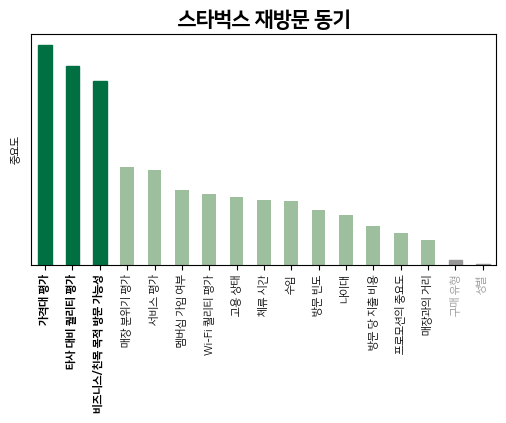

In [215]:
import matplotlib.pyplot as plt
from scipy.stats import gmean

# 시각화
plt.rc('font', family='NanumSquare_ac')
coef_show = coef_df.plot(
    kind='bar',
    x='변수',
    y='중요도',
    yticks=[],
    legend=False,
    figsize=(6, 3),
    fontsize=8,
    color='#9DBF9E'
)
plt.title('스타벅스 재방문 동기', fontsize=15, fontweight=900)
plt.xlabel(None)
plt.ylabel('중요도', fontsize=8)

# 큰 값 강조
max_highlight = [0, 1, 2]
for i, (bar, label) in enumerate(zip(coef_show.patches, coef_show.get_xticklabels())):
    if i in max_highlight:
        bar.set_color('#007042')
        label.set_fontweight(900)

# 작은 값 강조
min_highlight = [15, 16]
for i, (bar, label) in enumerate(zip(coef_show.patches, coef_show.get_xticklabels())):
    if i in min_highlight:
        bar.set_color('#969696')
        label.set_color('#969696')
        
plt.show()

스타벅스 재방문 의향에 상대적으로 큰 영향을 끼치는 요인은 **가격대 평가, 타사 대비 퀄리티 평가, 비즈니스/친목 목적 방문 가능성**으로 분석된다. 이때 비즈니스/친목 목적 방문 가능성은 여러 요소를 종합적으로 고려한 평가 지표이므로, 말레이시아에서 스타벅스의 경쟁력은 **합리적인 가격대와 높은 퀄리티**에서 온다고 짐작할 수 있을 것이다.

또한 **구매 유형과 성별**은 스타벅스 재방문 의사결정과는 무관한 요인들로 나타났다. 구매 유형은 매장 이용, 포장, 드라이브 쓰루 등 이용자의 행동 패턴을 나타내는데, 의외로 그 행동 유형과 재방문 의사 사이에는 관련성이 매우 작다는 결과가 나왔다. 그 외 방문 당 지출 비용, 프로모션의 중요도, 매장과의 거리 등도 평균 이하의 중요도로 분석되었다.

## 6. 후기

말레이시아의 스타벅스 설문조사 결과를 토대로 스타벅스 재방문 의사에 큰 영향을 미치는 요인이 무엇인지 Logistic Regression 모델 학습을 통해 분석해 보았다. 그 결과 **합리적인 가격**과 **업계 평균 이상의 퀄리티**가 중요하게 고려되는 점을 파악할 수 있었으며, **사용자의 구매 유형**과 **성별**은 크게 관련없는 요인으로 분석되었다.

분석을 통해 얻은 결과를 토대로 말레이시아 시장에서 카페 업종이 살아남기 위해서는 어떤 스탠스를 취해야 하는지 대략적으로 구상해 볼 수 있겠다. 예를 들어, **고급화 전략**을 채택하여 높은 품질의 커피를 제공하는 방법을 선택할 수 있다. 다만 과도하게 높은 가격에는 역효과가 날 가능성이 높으므로 사용자가 **합리적이라고 느낄 만한 가격**을 책정하는 것 역시 중요하다. 말레이시아 사용자들은 방문 당 지출 비용(중요도 하위 TOP5)에 크게 개의치 않는 경향을 보였기에, 제공하는 서비스에 상응하는 가격대만 책정한다면 고급화 전략이 충분히 먹혀 들어갈 것으로 예측할 수 있다.

본 분석에서 아쉬웠던 점은 데이터 표본이 다른 국가의 특성을 반영하고 있어 **한국 스타벅스에 대입하기엔 다소 괴리가 있다**는 것이다. 예를 들어, 한국에서는 마치 집 앞 마실 나가듯 카페에 방문하는 경우가 많다. 따라서 한국에서는 매장과의 거리가 상당히 중요한 요인이 될 것으로 예측할 수 있다. 그런데 말레이시아에서는 매장과의 거리가 하위 TOP3에 해당할 정도로 비중 낮은 요인으로 분석되었다. 이런 식으로, 카페 관련 문화 차이가 결과 해석에 복합적인 영향을 끼칠 여지가 있다.

또한 데이터의 수가 너무 적다는 점도 아쉬웠다. 고작 120여 개에 불과한 데이터로 정밀한 예측 모델을 생성해 낼 수는 없었다. 추후 기회가 된다면 **한국 시장**에서 수집한 **충분한 양**의 데이터를 바탕으로 비슷한 분석을 다시 진행해 보고 싶다.